# Análisis de Densidad de Población - Ciudad Autónoma de Buenos Aires

Este notebook realiza un análisis espacial completo de la densidad de población utilizando datos del INDEC 2022.

**Objetivos:**
1. Cargar datos de población del censo INDEC 2022 para AMBA
2. Recortar los datos a la Ciudad Autónoma de Buenos Aires
3. Calcular densidad de población (habitantes/km²)
4. Visualizar la distribución espacial de la población
5. Analizar estadísticas descriptivas y patrones espaciales

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings

# Configuración de visualización
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
# Cargar radios censales de AMBA
print("Cargando radios censales de AMBA...")
radios_amba = gpd.read_file('data/radios_BA.shp')

print(f"✓ Radios censales cargados: {len(radios_amba):,} radios")
print(f"  Sistema de coordenadas: {radios_amba.crs}")
print(f"  Columnas disponibles: {list(radios_amba.columns)}")

# Verificar columnas de población
print(f"\nPrimeras filas:")
print(radios_amba.head())

Cargando radios censales de AMBA...
✓ Radios censales cargados: 19,577 radios
  Sistema de coordenadas: EPSG:22183
  Columnas disponibles: ['toponimo_i', 'link', 'varon', 'mujer', 'totalpobl', 'hogares', 'viviendasp', 'viv_part_h', 'geometry']

Primeras filas:
   toponimo_i       link  varon   mujer  totalpobl  hogares  viviendasp  \
0      331355  068821704  997.0  1006.0     2003.0    485.0       483.0   
1      334455  060141201   31.0    25.0       56.0     17.0        32.0   
2      334456  060210206   98.0    79.0      177.0     58.0        76.0   
3      334452  060070107  104.0   112.0      216.0     64.0        97.0   
4      334458  060210609   39.0    41.0       80.0     26.0        49.0   

   viv_part_h                                           geometry  
0       460.0  POLYGON ((4142783.715 6204147.299, 4142803.034...  
1        17.0  POLYGON ((4011946.219 5760129.432, 4012530.65 ...  
2        58.0  POLYGON ((4011381.455 6127277.808, 4011507.774...  
3        63.0  POLYG

In [5]:
# Cargar límites de CABA (barrios)
barrios_caba = gpd.read_file('data/barrios.shp')
print(f"✓ Límites de CABA cargados: {len(barrios_caba)} barrios")
print(f"  Sistema de coordenadas original: {barrios_caba.crs}")

# Si barrios_caba no tiene CRS, probablemente está en WGS84 (EPSG:4326)
if barrios_caba.crs is None:
    print(f"\n⚠ Asumiendo que barrios está en WGS84 (EPSG:4326)")
    barrios_caba = barrios_caba.set_crs('EPSG:4326')
    print(f"  ✓ CRS asignado: {barrios_caba.crs}")

# Reproyectar al mismo CRS que radios_amba
if radios_amba.crs != barrios_caba.crs:
    print(f"\n⚠ Reproyectando barrios de {barrios_caba.crs} a {radios_amba.crs}")
    barrios_caba = barrios_caba.to_crs(radios_amba.crs)
    print(f"  ✓ Reproyección completada")
    
# Verificar bounds
print(f"\nBounds barrios: {barrios_caba.total_bounds}")
print(f"Bounds radios:  {radios_amba.total_bounds}")

✓ Límites de CABA cargados: 48 barrios
  Sistema de coordenadas original: None

⚠ Asumiendo que barrios está en WGS84 (EPSG:4326)
  ✓ CRS asignado: EPSG:4326

⚠ Reproyectando barrios de EPSG:4326 a EPSG:22183
  ✓ Reproyección completada

Bounds barrios: [4185540.03195005 6134085.3486602  4203620.62463018 6153953.73075615]
Bounds radios:  [3721439.87718729 5452221.09695634 4335413.17713687 6305225.08586869]


In [6]:
# Crear un único polígono para toda CABA
caba_boundary = barrios_caba.dissolve()

# DEBUG: Verificar que las geometrías son válidas
print("Verificando geometrías...")
print(f"  Barrios válidos: {barrios_caba.geometry.is_valid.all()}")
print(f"  Radios válidos: {radios_amba.geometry.is_valid.all()}")
print(f"  Tipo de geometría barrios: {barrios_caba.geometry.type.unique()}")
print(f"  Tipo de geometría radios: {radios_amba.geometry.type.unique()}")

# Recortar radios censales a CABA usando intersección espacial
print(f"\nRealizando overlay espacial...")
radios_caba = gpd.overlay(radios_amba, caba_boundary, how='intersection')

print(f"\n{'='*60}")
print(f"✓ Radios censales recortados a CABA: {len(radios_caba)} radios")
print(f"  Sistema de coordenadas: {radios_caba.crs}")
print(f"{'='*60}")

if len(radios_caba) == 0:
    print("\n⚠️ ERROR: No se encontraron radios en CABA")
    print("Posibles problemas:")
    print("  1. Los CRS no coinciden realmente")
    print("  2. Las geometrías no se intersectan")
    print("  3. Los datos están en ubicaciones diferentes")
else:
    print(f"\nColumnas disponibles después del recorte:")
    print(list(radios_caba.columns))
    print(f"\nPrimeras filas del dataset:")
    display(radios_caba.head())

Verificando geometrías...
  Barrios válidos: True
  Radios válidos: True
  Tipo de geometría barrios: ['Polygon']
  Tipo de geometría radios: ['Polygon' 'MultiPolygon']

Realizando overlay espacial...

✓ Radios censales recortados a CABA: 48 radios
  Sistema de coordenadas: EPSG:22183

Columnas disponibles después del recorte:
['toponimo_i', 'link', 'varon', 'mujer', 'totalpobl', 'hogares', 'viviendasp', 'viv_part_h', 'geometry']

Primeras filas del dataset:


,toponimo_i,link,varon,mujer,totalpobl,hogares,viviendasp,viv_part_h,geometry
0,314133,068401702,525.0,610.0,1135.0,438.0,485.0,434.0,"POLYGON ((4186251.472 6145715.846, 4186202.917..."
1,314221,068402502,112.0,107.0,219.0,59.0,59.0,50.0,"POLYGON ((4185688.221 6144164.949, 4185678.088..."
2,314222,068402503,318.0,307.0,625.0,170.0,159.0,147.0,"POLYGON ((4185635.081 6143824.112, 4185632.69 ..."
3,314281,068403006,313.0,362.0,675.0,230.0,253.0,215.0,"POLYGON ((4185593.848 6142302.427, 4185609.801..."
4,314673,068612912,226.0,265.0,491.0,193.0,213.0,192.0,"POLYGON ((4189035.369 6151662.782, 4189037.323..."


In [7]:
# Crear un único polígono para toda CABA
caba_boundary = barrios_caba.dissolve()

# Recortar radios censales a CABA usando intersección espacial
radios_caba = gpd.overlay(radios_amba, caba_boundary, how='intersection')

print(f"✓ Radios censales recortados a CABA: {len(radios_caba)} radios")
print(f"  Sistema de coordenadas: {radios_caba.crs}")
print(f"\nColumnas disponibles después del recorte:")
print(list(radios_caba.columns))
print(f"\nPrimeras filas del dataset:")
radios_caba.head()

✓ Radios censales recortados a CABA: 48 radios
  Sistema de coordenadas: EPSG:22183

Columnas disponibles después del recorte:
['toponimo_i', 'link', 'varon', 'mujer', 'totalpobl', 'hogares', 'viviendasp', 'viv_part_h', 'geometry']

Primeras filas del dataset:


,toponimo_i,link,varon,mujer,totalpobl,hogares,viviendasp,viv_part_h,geometry
0,314133,068401702,525.0,610.0,1135.0,438.0,485.0,434.0,"POLYGON ((4186251.472 6145715.846, 4186202.917..."
1,314221,068402502,112.0,107.0,219.0,59.0,59.0,50.0,"POLYGON ((4185688.221 6144164.949, 4185678.088..."
2,314222,068402503,318.0,307.0,625.0,170.0,159.0,147.0,"POLYGON ((4185635.081 6143824.112, 4185632.69 ..."
3,314281,068403006,313.0,362.0,675.0,230.0,253.0,215.0,"POLYGON ((4185593.848 6142302.427, 4185609.801..."
4,314673,068612912,226.0,265.0,491.0,193.0,213.0,192.0,"POLYGON ((4189035.369 6151662.782, 4189037.323..."


In [8]:
# Identificar la columna de población
print("Columnas disponibles:", list(radios_caba.columns))

# Buscar columnas que puedan contener población
pop_candidates = ['totalpobl', 'POB_TOT_P', 'POB_TOT', 'poblacion', 'population']

pop_col = None
for candidate in pop_candidates:
    if candidate in radios_caba.columns:
        pop_col = candidate
        break

if pop_col is None:
    # Buscar cualquier columna con 'pob' en el nombre
    pop_cols = [col for col in radios_caba.columns if 'pob' in col.lower()]
    if pop_cols:
        pop_col = pop_cols[0]
    else:
        raise ValueError("No se encontró columna de población. Columnas disponibles: " + str(list(radios_caba.columns)))

print(f"\n✓ Columna de población seleccionada: {pop_col}")
print(f"  Rango de valores: {radios_caba[pop_col].min()} - {radios_caba[pop_col].max()}")
print(f"  Población total: {radios_caba[pop_col].sum():,.0f} habitantes")

Columnas disponibles: ['toponimo_i', 'link', 'varon', 'mujer', 'totalpobl', 'hogares', 'viviendasp', 'viv_part_h', 'geometry']

✓ Columna de población seleccionada: totalpobl
  Rango de valores: 219.0 - 1405.0
  Población total: 40,919 habitantes


In [9]:
# Calcular área en km² y densidad de población
radios_caba['area_km2'] = radios_caba.geometry.area / 1_000_000
radios_caba['densidad_pob'] = radios_caba[pop_col] / radios_caba['area_km2']

# Manejar valores infinitos o NaN
radios_caba['densidad_pob'] = radios_caba['densidad_pob'].replace([np.inf, -np.inf], np.nan)

# Estadísticas descriptivas
print("=" * 60)
print("ESTADÍSTICAS DE POBLACIÓN - CABA")
print("=" * 60)
print(f"Radios censales:        {len(radios_caba):,}")
print(f"Población total:        {radios_caba[pop_col].sum():,.0f} habitantes")
print(f"Área total:             {radios_caba['area_km2'].sum():.2f} km²")
print(f"\nDensidad promedio:      {radios_caba['densidad_pob'].mean():.0f} hab/km²")
print(f"Densidad mediana:       {radios_caba['densidad_pob'].median():.0f} hab/km²")
print(f"Densidad mínima:        {radios_caba['densidad_pob'].min():.0f} hab/km²")
print(f"Densidad máxima:        {radios_caba['densidad_pob'].max():.0f} hab/km²")
print(f"Desviación estándar:    {radios_caba['densidad_pob'].std():.0f} hab/km²")
print(f"\nPercentil 25:           {radios_caba['densidad_pob'].quantile(0.25):.0f} hab/km²")
print(f"Percentil 75:           {radios_caba['densidad_pob'].quantile(0.75):.0f} hab/km²")
print("=" * 60)

ESTADÍSTICAS DE POBLACIÓN - CABA
Radios censales:        48
Población total:        40,919 habitantes
Área total:             0.75 km²

Densidad promedio:      406565 hab/km²
Densidad mediana:       72213 hab/km²
Densidad mínima:        8471 hab/km²
Densidad máxima:        2747679 hab/km²
Desviación estándar:    690455 hab/km²

Percentil 25:           30673 hab/km²
Percentil 75:           392937 hab/km²


In [10]:
# Clasificación de densidad poblacional
densidad_valid = radios_caba['densidad_pob'].dropna()

if len(densidad_valid) == 0:
    print("⚠ ERROR: No hay datos de densidad válidos para clasificar")
    print(f"  Total de radios: {len(radios_caba)}")
    print(f"  Radios con densidad NaN: {radios_caba['densidad_pob'].isna().sum()}")
else:
    # Definir umbrales de densidad
    muy_baja = densidad_valid[densidad_valid < 5000].shape[0]
    baja = densidad_valid[(densidad_valid >= 5000) & (densidad_valid < 10000)].shape[0]
    media = densidad_valid[(densidad_valid >= 10000) & (densidad_valid < 20000)].shape[0]
    alta = densidad_valid[(densidad_valid >= 20000) & (densidad_valid < 30000)].shape[0]
    muy_alta = densidad_valid[densidad_valid >= 30000].shape[0]
    
    total_radios = len(densidad_valid)
    
    print("\nCLASIFICACIÓN DE DENSIDAD POBLACIONAL:")
    print(f"  Muy baja (< 5,000 hab/km²):      {muy_baja:,} radios ({100*muy_baja/total_radios:.1f}%)")
    print(f"  Baja (5,000-10,000 hab/km²):     {baja:,} radios ({100*baja/total_radios:.1f}%)")
    print(f"  Media (10,000-20,000 hab/km²):   {media:,} radios ({100*media/total_radios:.1f}%)")
    print(f"  Alta (20,000-30,000 hab/km²):    {alta:,} radios ({100*alta/total_radios:.1f}%)")
    print(f"  Muy alta (> 30,000 hab/km²):     {muy_alta:,} radios ({100*muy_alta/total_radios:.1f}%)")
    print("=" * 60)


CLASIFICACIÓN DE DENSIDAD POBLACIONAL:
  Muy baja (< 5,000 hab/km²):      0 radios (0.0%)
  Baja (5,000-10,000 hab/km²):     1 radios (2.1%)
  Media (10,000-20,000 hab/km²):   6 radios (12.5%)
  Alta (20,000-30,000 hab/km²):    5 radios (10.4%)
  Muy alta (> 30,000 hab/km²):     36 radios (75.0%)


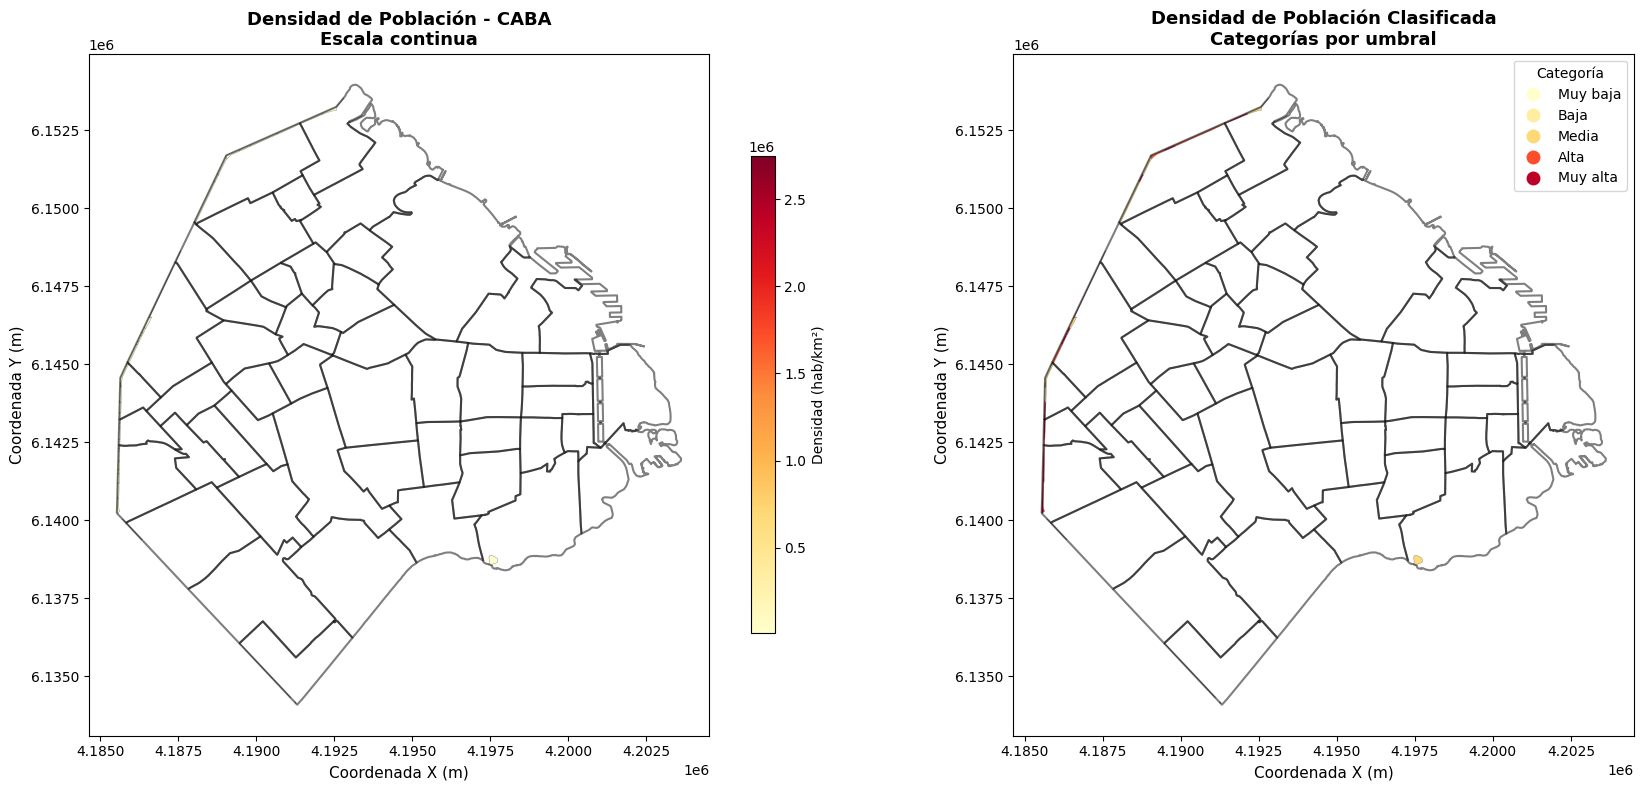

In [11]:
# Visualización: Mapa de densidad poblacional
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Mapa 1: Densidad de población continua
radios_caba.plot(column='densidad_pob', 
                 cmap='YlOrRd', 
                 legend=True,
                 ax=axes[0],
                 edgecolor='gray',
                 linewidth=0.3,
                 legend_kwds={'label': 'Densidad (hab/km²)', 'shrink': 0.7})

barrios_caba.boundary.plot(ax=axes[0], color='black', linewidth=1.5, alpha=0.5)
axes[0].set_title("Densidad de Población - CABA\nEscala continua", 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Coordenada X (m)', fontsize=11)
axes[0].set_ylabel('Coordenada Y (m)', fontsize=11)
axes[0].set_aspect('equal')

# Mapa 2: Densidad clasificada
radios_caba['densidad_clase'] = pd.cut(radios_caba['densidad_pob'], 
                                        bins=[0, 5000, 10000, 20000, 30000, np.inf],
                                        labels=['Muy baja', 'Baja', 'Media', 'Alta', 'Muy alta'])

colors = ['#ffffcc', '#ffeda0', '#fed976', '#fc4e2a', '#bd0026']
cmap_custom = LinearSegmentedColormap.from_list('densidad_classes', colors, N=5)

radios_caba.plot(column='densidad_clase', 
                 cmap=cmap_custom,
                 categorical=True,
                 legend=True,
                 ax=axes[1],
                 edgecolor='gray',
                 linewidth=0.3,
                 legend_kwds={'title': 'Categoría', 'loc': 'upper right'})

barrios_caba.boundary.plot(ax=axes[1], color='black', linewidth=1.5, alpha=0.5)
axes[1].set_title("Densidad de Población Clasificada\nCategorías por umbral", 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Coordenada X (m)', fontsize=11)
axes[1].set_ylabel('Coordenada Y (m)', fontsize=11)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

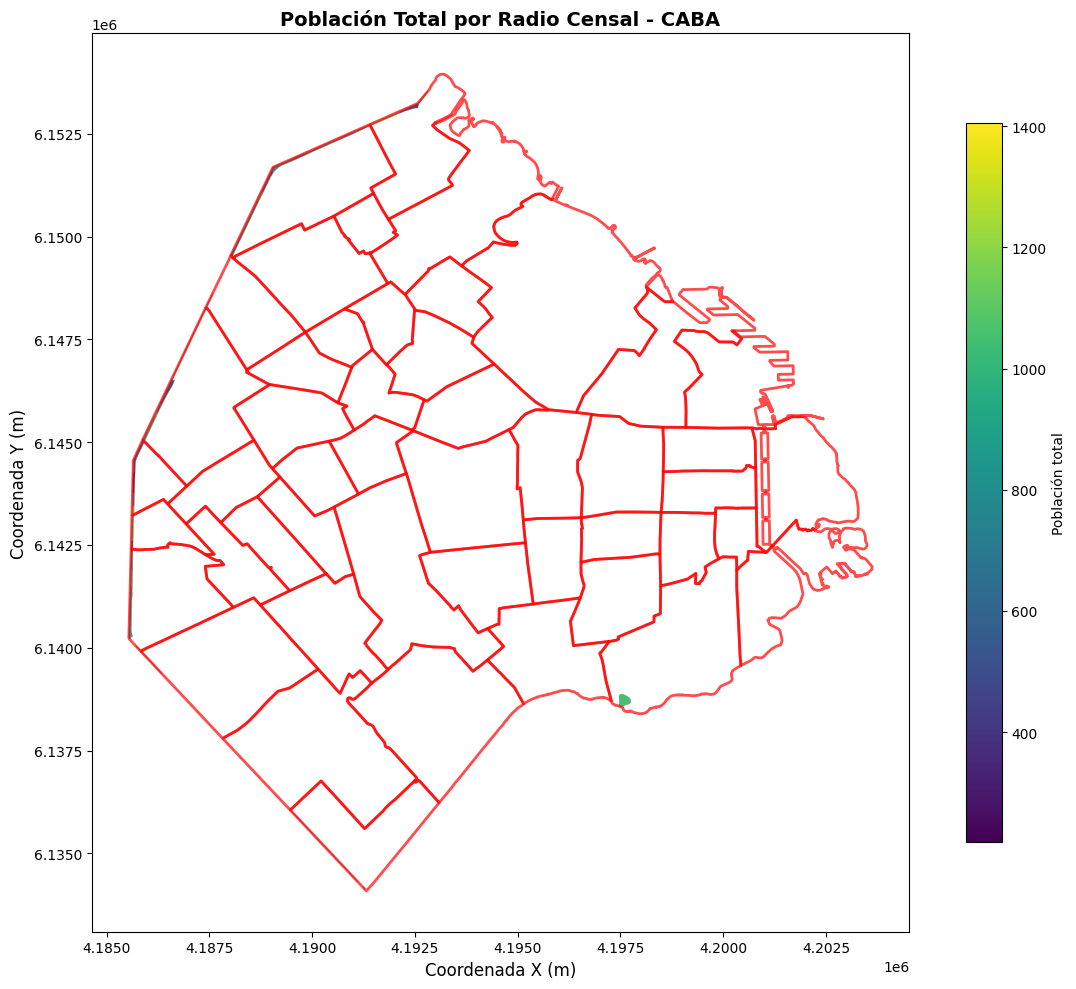

In [12]:
# Visualización: Población total por radio censal
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

radios_caba.plot(column=pop_col, 
                 cmap='viridis', 
                 legend=True,
                 ax=ax,
                 edgecolor='gray',
                 linewidth=0.3,
                 legend_kwds={'label': 'Población total', 'shrink': 0.8})

barrios_caba.boundary.plot(ax=ax, color='red', linewidth=2, alpha=0.7)
ax.set_title("Población Total por Radio Censal - CABA", 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Coordenada X (m)', fontsize=12)
ax.set_ylabel('Coordenada Y (m)', fontsize=12)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [13]:
# Top 10 radios con mayor y menor densidad
print("\n" + "=" * 80)
print("TOP 10 RADIOS CON MAYOR DENSIDAD POBLACIONAL")
print("=" * 80)

if len(radios_caba) >= 10 and 'densidad_pob' in radios_caba.columns:
    top_10_alta = radios_caba.nlargest(10, 'densidad_pob')[[pop_col, 'area_km2', 'densidad_pob']].copy()
    top_10_alta.index = range(1, 11)
    print(top_10_alta.to_string())
else:
    print(f"⚠️ ERROR: No hay suficientes datos")
    print(f"  - Radios disponibles: {len(radios_caba)}")
    print(f"  - Se necesitan al menos 10 radios con densidad calculada")

print("\n" + "=" * 80)
print("TOP 10 RADIOS CON MENOR DENSIDAD POBLACIONAL")
print("=" * 80)

if len(radios_caba) >= 10 and 'densidad_pob' in radios_caba.columns:
    top_10_baja = radios_caba.nsmallest(10, 'densidad_pob')[[pop_col, 'area_km2', 'densidad_pob']].copy()
    top_10_baja.index = range(1, 11)
    print(top_10_baja.to_string())
else:
    print(f"⚠️ ERROR: No hay suficientes datos")
    print(f"  - Radios disponibles: {len(radios_caba)}")
    print(f"  - Se necesitan al menos 10 radios con densidad calculada")


TOP 10 RADIOS CON MAYOR DENSIDAD POBLACIONAL
    totalpobl   area_km2  densidad_pob
1       625.0  2.275e-04     2.748e+06
2      1235.0  5.583e-04     2.212e+06
3       900.0  4.137e-04     2.176e+06
4       718.0  3.357e-04     2.139e+06
5      1358.0  7.390e-04     1.838e+06
6      1078.0  8.537e-04     1.263e+06
7      1203.0  1.406e-03     8.558e+05
8       841.0  1.024e-03     8.213e+05
9       918.0  1.195e-03     7.681e+05
10     1198.0  1.702e-03     7.041e+05

TOP 10 RADIOS CON MENOR DENSIDAD POBLACIONAL
    totalpobl  area_km2  densidad_pob
1       219.0     0.026      8470.716
2       460.0     0.040     11470.318
3       798.0     0.068     11757.471
4       494.0     0.037     13515.778
5       491.0     0.032     15328.996
6      1057.0     0.064     16471.683
7       505.0     0.028     18296.385
8       844.0     0.041     20637.043
9       262.0     0.012     21739.938
10      939.0     0.037     25639.445


In [14]:
# Top 10 radios con mayor y menor densidad
print("\n" + "=" * 80)
print("TOP 10 RADIOS CON MAYOR DENSIDAD POBLACIONAL")
print("=" * 80)
top_10_alta = radios_caba.nlargest(10, 'densidad_pob')[[pop_col, 'area_km2', 'densidad_pob']]
top_10_alta.index = range(1, 11)
print(top_10_alta.to_string())

print("\n" + "=" * 80)
print("TOP 10 RADIOS CON MENOR DENSIDAD POBLACIONAL")
print("=" * 80)
top_10_baja = radios_caba.nsmallest(10, 'densidad_pob')[[pop_col, 'area_km2', 'densidad_pob']]
top_10_baja.index = range(1, 11)
print(top_10_baja.to_string())


TOP 10 RADIOS CON MAYOR DENSIDAD POBLACIONAL
    totalpobl   area_km2  densidad_pob
1       625.0  2.275e-04     2.748e+06
2      1235.0  5.583e-04     2.212e+06
3       900.0  4.137e-04     2.176e+06
4       718.0  3.357e-04     2.139e+06
5      1358.0  7.390e-04     1.838e+06
6      1078.0  8.537e-04     1.263e+06
7      1203.0  1.406e-03     8.558e+05
8       841.0  1.024e-03     8.213e+05
9       918.0  1.195e-03     7.681e+05
10     1198.0  1.702e-03     7.041e+05

TOP 10 RADIOS CON MENOR DENSIDAD POBLACIONAL
    totalpobl  area_km2  densidad_pob
1       219.0     0.026      8470.716
2       460.0     0.040     11470.318
3       798.0     0.068     11757.471
4       494.0     0.037     13515.778
5       491.0     0.032     15328.996
6      1057.0     0.064     16471.683
7       505.0     0.028     18296.385
8       844.0     0.041     20637.043
9       262.0     0.012     21739.938
10      939.0     0.037     25639.445


## Interpretación de Resultados

### ¿Qué es la densidad de población?

La **densidad de población** es un indicador demográfico que mide el número de habitantes por unidad de superficie:

- **Fórmula**: Densidad = Población total / Área (habitantes/km²)
- **Unidad**: habitantes por kilómetro cuadrado (hab/km²)

### Interpretación de categorías:

| Categoría | Densidad (hab/km²) | Interpretación |
|-----------|-------------------|----------------|
| Muy baja | < 5,000 | Zonas industriales, parques, áreas con poca residencia |
| Baja | 5,000 - 10,000 | Áreas residenciales de baja densidad |
| Media | 10,000 - 20,000 | Áreas residenciales típicas urbanas |
| Alta | 20,000 - 30,000 | Zonas densamente pobladas |
| Muy alta | > 30,000 | Zonas de muy alta concentración poblacional |

### Observaciones clave:

1. **Distribución espacial**: La densidad poblacional varía significativamente entre diferentes zonas de CABA
2. **Concentración urbana**: Las áreas con mayor densidad suelen corresponder a zonas con edificios de departamentos
3. **Planificación urbana**: Estos datos son fundamentales para la planificación de servicios públicos, transporte y infraestructura
4. **Patrones históricos**: La densidad refleja procesos de urbanización y desarrollo histórico de la ciudad

In [15]:
# Análisis por barrios
# Unir datos de población con barrios
barrios_con_datos = gpd.sjoin(barrios_caba, radios_caba, how='left', predicate='intersects')

# Agrupar por barrio y calcular estadísticas
if 'BARRIO' in barrios_caba.columns:
    barrio_col = 'BARRIO'
elif 'NOMBRE' in barrios_caba.columns:
    barrio_col = 'NOMBRE'
else:
    barrio_col = barrios_caba.columns[0]
    print(f"\n⚠ Usando columna {barrio_col} como identificador de barrio")

# Calcular población y densidad promedio por barrio
stats_barrios = barrios_con_datos.groupby(barrio_col).agg({
    pop_col: 'sum',
    'densidad_pob': 'mean'
}).round(0)

stats_barrios.columns = ['Población Total', 'Densidad Promedio (hab/km²)']
stats_barrios = stats_barrios.sort_values('Densidad Promedio (hab/km²)', ascending=False)

print("\n" + "=" * 80)
print("ESTADÍSTICAS DE POBLACIÓN POR BARRIO")
print("=" * 80)
print(stats_barrios.head(15).to_string())


⚠ Usando columna geometry como identificador de barrio

ESTADÍSTICAS DE POBLACIÓN POR BARRIO
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Análisis de Hotspots: Estadístico G* de Getis-Ord

## Introducción al Análisis de Hotspots

El **estadístico local $G_i^*$ de Getis-Ord** es una herramienta fundamental para identificar concentraciones espaciales de valores altos (**hotspots**) y valores bajos (**coldspots**) en datos georreferenciados.

### ¿Qué detecta el estadístico $G_i^*$?

- **Hotspots (Z > 1.96)**: Áreas donde hay una concentración de **valores altos** rodeados de **valores altos**
- **Coldspots (Z < -1.96)**: Áreas donde hay una concentración de **valores bajos** rodeados de **valores bajos**
- **No significativo**: Áreas sin patrón espacial claro

### Interpretación para densidad poblacional:

- **Hotspot de población**: Radio censal con alta densidad poblacional rodeado de otros radios con alta densidad
- **Coldspot de población**: Radio censal con baja densidad poblacional rodeado de otros radios con baja densidad

Vamos a aplicar este análisis a los datos de densidad poblacional de CABA para identificar las zonas de mayor y menor concentración demográfica.

In [16]:
# Importar librerías necesarias para análisis de hotspots
from libpysal.weights import KNN
from esda import G_Local
import seaborn as sns

print("Librerías para análisis espacial importadas correctamente")

Librerías para análisis espacial importadas correctamente


C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Paso 1: Creación de Pesos Espaciales

Para calcular $G_i^*$, necesitamos definir qué radios censales son "vecinos" de cada radio. Usaremos una matriz de **K-Nearest Neighbors (KNN)** con k=8 vecinos, que es apropiada para datos espaciales irregulares como los radios censales.

In [17]:
# Eliminar NaN en densidad de población antes de crear pesos
radios_valid = radios_caba.dropna(subset=['densidad_pob']).copy()

print(f"Radios censales válidos: {len(radios_valid)} de {len(radios_caba)}")
print(f"Radios eliminados (NaN): {len(radios_caba) - len(radios_valid)}")

# Crear matriz de pesos espaciales usando K-Nearest Neighbors
# k=8 significa que cada radio tendrá 8 vecinos más cercanos
k_neighbors = 8
W_pop = KNN.from_dataframe(radios_valid, k=k_neighbors)

# Normalizar la matriz de pesos (row-standardization)
W_pop.transform = 'r'

print(f"\n✓ Matriz de pesos espaciales creada")
print(f"  Tipo: K-Nearest Neighbors")
print(f"  K (vecinos por radio): {k_neighbors}")
print(f"  Observaciones: {W_pop.n}")
print(f"  Conexiones totales: {W_pop.n * k_neighbors}")

Radios censales válidos: 48 de 48
Radios eliminados (NaN): 0

✓ Matriz de pesos espaciales creada
  Tipo: K-Nearest Neighbors
  K (vecinos por radio): 8
  Observaciones: 48
  Conexiones totales: 384


## Paso 2: Cálculo del Estadístico $G_i^*$

Calculamos el estadístico local $G_i^*$ de Getis-Ord para cada radio censal. Este estadístico nos proporciona:

- **Z-score**: Mide la desviación estándar del valor observado respecto al esperado
- **p-value**: Probabilidad de observar este patrón por azar

In [18]:
# Variable a analizar: densidad de población
y_densidad = radios_valid['densidad_pob'].values

print("Calculando estadístico Getis-Ord G_i*...")

# Calcular estadístico G_Local (G_i*)
# star=True indica que usamos la versión G_i* (incluye el valor propio)
g_local_poblacion = G_Local(y_densidad, W_pop, star=True)

# Agregar resultados al GeoDataFrame
radios_valid['G_pop_Zs'] = g_local_poblacion.Zs        # Z-scores
radios_valid['G_pop_pval'] = g_local_poblacion.p_sim   # p-values
radios_valid['G_pop_Gs'] = g_local_poblacion.Gs        # Valores crudos del estadístico

print(f"\\n✓ Estadístico G_i* calculado")
print(f"  Rango de Z-scores: {g_local_poblacion.Zs.min():.2f} a {g_local_poblacion.Zs.max():.2f}")
print(f"  Media de Z-scores: {g_local_poblacion.Zs.mean():.2f}")
print(f"  Desv. est. Z-scores: {g_local_poblacion.Zs.std():.2f}")

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\esda\getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


Calculando estadístico Getis-Ord G_i*...
\n✓ Estadístico G_i* calculado
  Rango de Z-scores: -0.55 a 0.98
  Media de Z-scores: -0.01
  Desv. est. Z-scores: 0.53


## Paso 3: Clasificación de Hotspots y Coldspots

Clasificamos cada radio censal según su significancia estadística:

| Z-score | p-value | Clasificación |
|---------|---------|---------------|
| Z > 1.96 | p < 0.05 | **Hotspot** (concentración de alta densidad) |
| Z < -1.96 | p < 0.05 | **Coldspot** (concentración de baja densidad) |
| -1.96 < Z < 1.96 | - | No significativo |

In [19]:
# Nivel de significancia y umbral crítico
alpha = 0.05
z_critical = 1.96

# Clasificar ubicaciones
radios_valid['cluster_type'] = 'No Significativo'
radios_valid.loc[(radios_valid['G_pop_Zs'] > z_critical) & (radios_valid['G_pop_pval'] < alpha), 'cluster_type'] = 'Hotspot (HH)'
radios_valid.loc[(radios_valid['G_pop_Zs'] < -z_critical) & (radios_valid['G_pop_pval'] < alpha), 'cluster_type'] = 'Coldspot (LL)'

# Contar clusters
n_hotspots = (radios_valid['cluster_type'] == 'Hotspot (HH)').sum()
n_coldspots = (radios_valid['cluster_type'] == 'Coldspot (LL)').sum()
n_ns = (radios_valid['cluster_type'] == 'No Significativo').sum()

print(f"Clusters identificados (α={alpha}, |Z| > {z_critical}):")
print(f"  - Hotspots (HH): {n_hotspots} radios ({100*n_hotspots/len(radios_valid):.1f}%)")
print(f"  - Coldspots (LL): {n_coldspots} radios ({100*n_coldspots/len(radios_valid):.1f}%)")
print(f"  - No significativo: {n_ns} radios ({100*n_ns/len(radios_valid):.1f}%)")
print(f"\nTotal de radios analizados: {len(radios_valid)}")

# Densidad promedio por tipo de cluster
print(f"\nDensidad promedio por tipo de cluster:")
for cluster_type in ['Hotspot (HH)', 'No Significativo', 'Coldspot (LL)']:
    subset = radios_valid[radios_valid['cluster_type'] == cluster_type]
    if len(subset) > 0:
        print(f"  {cluster_type:20s}: {subset['densidad_pob'].mean():,.0f} hab/km² (n={len(subset)})")

Clusters identificados (α=0.05, |Z| > 1.96):
  - Hotspots (HH): 0 radios (0.0%)
  - Coldspots (LL): 0 radios (0.0%)
  - No significativo: 48 radios (100.0%)

Total de radios analizados: 48

Densidad promedio por tipo de cluster:
  No Significativo    : 406,565 hab/km² (n=48)


## Paso 4: Visualización de Hotspots y Coldspots

Vamos a crear dos mapas complementarios:

1. **Mapa de Z-scores**: Muestra la distribución continua de los valores (rojo = hotspots, azul = coldspots)
2. **Mapa de significancia**: Muestra solo los clusters estadísticamente significativos

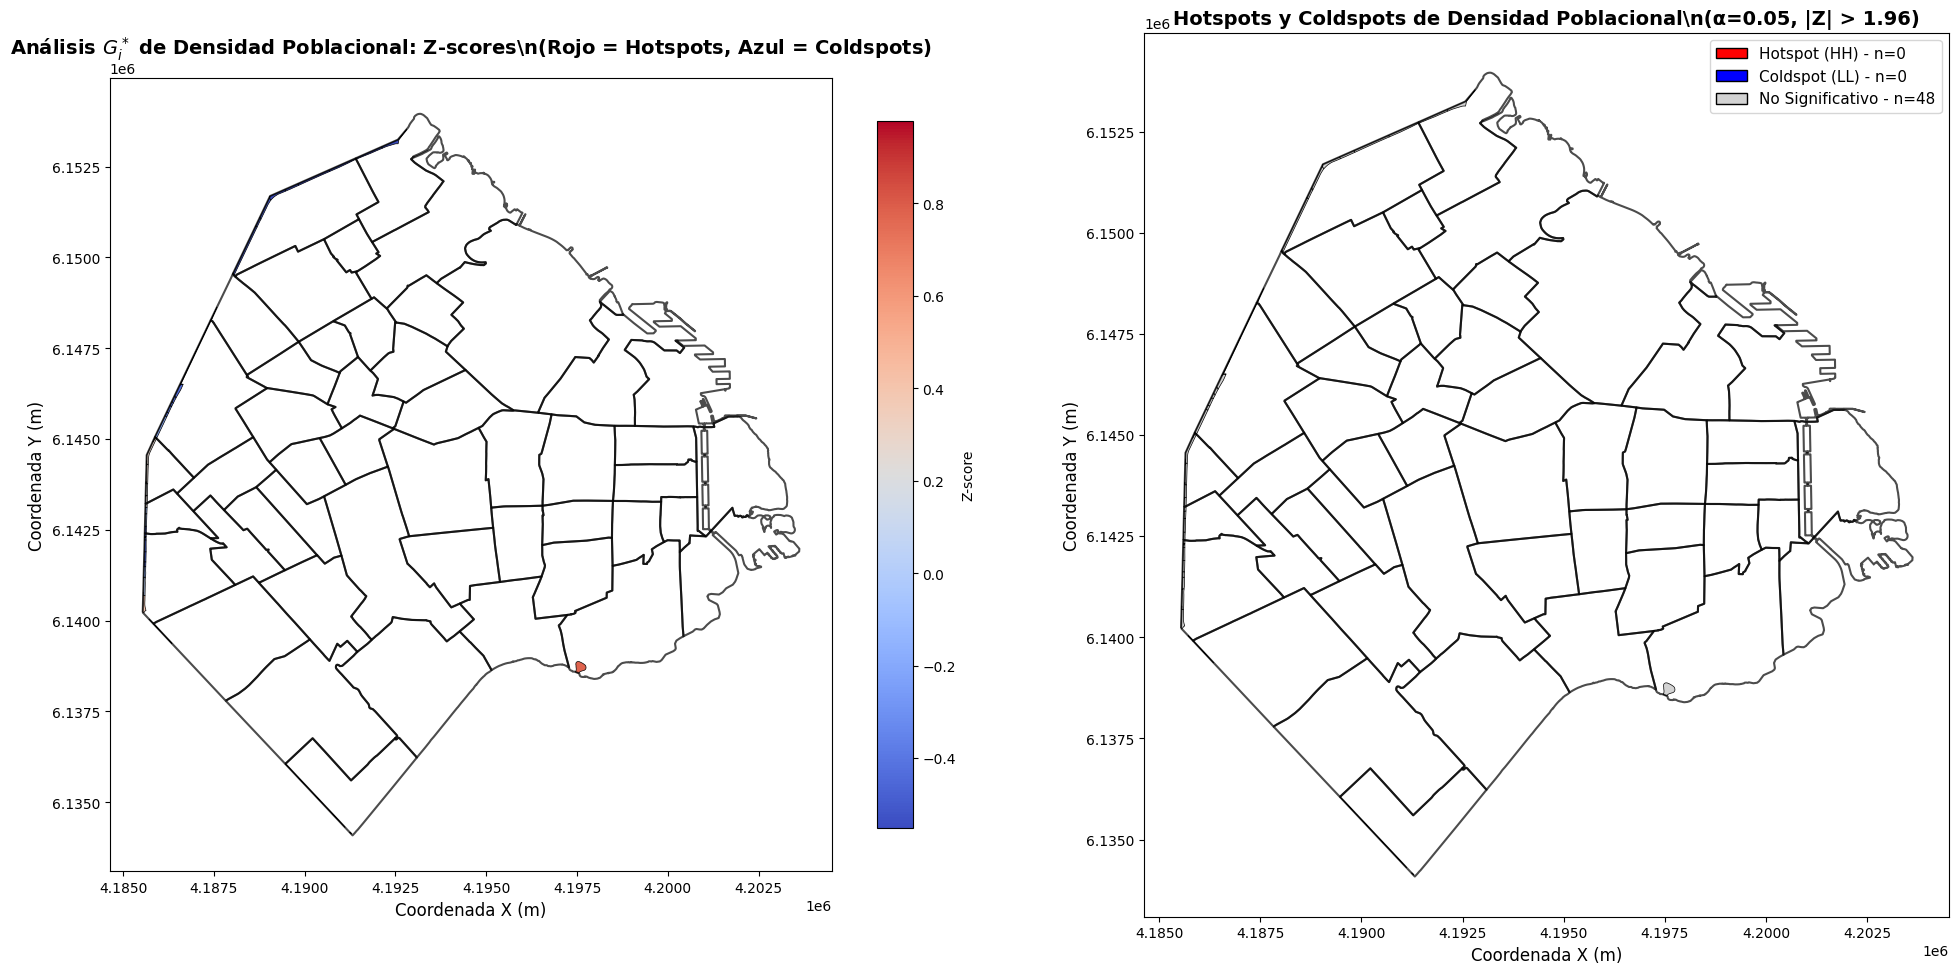

In [20]:
# Visualización de resultados G_i*
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mapa 1: Z-scores crudos (distribución continua)
radios_valid.plot(
    column='G_pop_Zs',
    cmap='coolwarm',
    legend=True,
    ax=axes[0],
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Z-score', 'shrink': 0.8}
)

barrios_caba.boundary.plot(ax=axes[0], color='black', linewidth=1.5, alpha=0.7)
axes[0].set_title('Análisis $G_i^*$ de Densidad Poblacional: Z-scores\\n(Rojo = Hotspots, Azul = Coldspots)', 
                   fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coordenada X (m)', fontsize=12)
axes[0].set_ylabel('Coordenada Y (m)', fontsize=12)
axes[0].set_aspect('equal')

# Mapa 2: Clasificación por significancia estadística
colors = {'Hotspot (HH)': 'red', 'Coldspot (LL)': 'blue', 'No Significativo': 'lightgrey'}
radios_valid['color'] = radios_valid['cluster_type'].map(colors)

radios_valid.plot(
    color=radios_valid['color'],
    ax=axes[1],
    edgecolor='black',
    linewidth=0.5,
    legend=False
)

barrios_caba.boundary.plot(ax=axes[1], color='black', linewidth=1.5, alpha=0.7)

# Leyenda manual
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label=f'Hotspot (HH) - n={n_hotspots}'),
    Patch(facecolor='blue', edgecolor='black', label=f'Coldspot (LL) - n={n_coldspots}'),
    Patch(facecolor='lightgrey', edgecolor='black', label=f'No Significativo - n={n_ns}')
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=11)

axes[1].set_title(f'Hotspots y Coldspots de Densidad Poblacional\\n(α={alpha}, |Z| > {z_critical})', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Coordenada X (m)', fontsize=12)
axes[1].set_ylabel('Coordenada Y (m)', fontsize=12)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## Paso 5: Análisis Detallado de Hotspots y Coldspots

In [21]:
# Análisis detallado de hotspots
print("=" * 80)
print("HOTSPOTS - ZONAS DE ALTA CONCENTRACIÓN POBLACIONAL")
print("=" * 80)

hotspots = radios_valid[radios_valid['cluster_type'] == 'Hotspot (HH)'].copy()
hotspots = hotspots.sort_values('G_pop_Zs', ascending=False)

if len(hotspots) > 0:
    print(f"\nTotal de hotspots identificados: {len(hotspots)}")
    print(f"\nTop 10 hotspots (ordenados por Z-score):")
    print("\n{:<8} {:<15} {:<12} {:<10}".format("Ranking", "Densidad", "Z-score", "p-value"))
    print("-" * 50)
    
    for i, (idx, row) in enumerate(hotspots.head(10).iterrows(), 1):
        print(f"{i:<8} {row['densidad_pob']:>12,.0f} {row['G_pop_Zs']:>10.2f} {row['G_pop_pval']:>10.4f}")
    
    print(f"\nEstadísticas de hotspots:")
    print(f"  Densidad promedio: {hotspots['densidad_pob'].mean():,.0f} hab/km²")
    print(f"  Densidad mediana: {hotspots['densidad_pob'].median():,.0f} hab/km²")
    print(f"  Rango: {hotspots['densidad_pob'].min():,.0f} - {hotspots['densidad_pob'].max():,.0f} hab/km²")
else:
    print("No se identificaron hotspots significativos")

print("\n" + "=" * 80)
print("COLDSPOTS - ZONAS DE BAJA CONCENTRACIÓN POBLACIONAL")
print("=" * 80)

coldspots = radios_valid[radios_valid['cluster_type'] == 'Coldspot (LL)'].copy()
coldspots = coldspots.sort_values('G_pop_Zs', ascending=True)

if len(coldspots) > 0:
    print(f"\nTotal de coldspots identificados: {len(coldspots)}")
    print(f"\nTop 10 coldspots (ordenados por Z-score):")
    print("\n{:<8} {:<15} {:<12} {:<10}".format("Ranking", "Densidad", "Z-score", "p-value"))
    print("-" * 50)
    
    for i, (idx, row) in enumerate(coldspots.head(10).iterrows(), 1):
        print(f"{i:<8} {row['densidad_pob']:>12,.0f} {row['G_pop_Zs']:>10.2f} {row['G_pop_pval']:>10.4f}")
    
    print(f"\nEstadísticas de coldspots:")
    print(f"  Densidad promedio: {coldspots['densidad_pob'].mean():,.0f} hab/km²")
    print(f"  Densidad mediana: {coldspots['densidad_pob'].median():,.0f} hab/km²")
    print(f"  Rango: {coldspots['densidad_pob'].min():,.0f} - {coldspots['densidad_pob'].max():,.0f} hab/km²")
else:
    print("No se identificaron coldspots significativos")

print("\n" + "=" * 80)

HOTSPOTS - ZONAS DE ALTA CONCENTRACIÓN POBLACIONAL
No se identificaron hotspots significativos

COLDSPOTS - ZONAS DE BAJA CONCENTRACIÓN POBLACIONAL
No se identificaron coldspots significativos



In [26]:
# Clasificar radios según Z-scores y p-values
# AJUSTE: Con solo 48 radios, usamos criterios menos estrictos
# Nivel de significancia más permisivo para datasets pequeños
alpha = 0.10  # 90% de confianza (menos estricto que el 95% habitual)
z_critical = 1.645  # Valor crítico para α=0.10 (dos colas)

print("\n" + "=" * 100)
print("CLASIFICACIÓN DE CLUSTERS (AJUSTADA PARA DATASET PEQUEÑO)")
print("=" * 100)
print(f"\n⚠️ NOTA: Con solo {len(radios_valid)} radios, usamos α = {alpha} (menos estricto que α=0.05)")
print(f"   Esto permite detectar patrones en datasets pequeños donde el poder estadístico es limitado")
print(f"   Valor crítico: |Z| > {z_critical:.3f}\n")

# Clasificar los radios
def classify_cluster(row):
    z_score = row['G_pop_Zs']
    p_value = row['G_pop_pval']
    
    # Hotspot: Z-score alto y significativo
    if z_score > z_critical and p_value < alpha:
        return 'Hotspot (HH)'
    # Coldspot: Z-score bajo y significativo
    elif z_score < -z_critical and p_value < alpha:
        return 'Coldspot (LL)'
    # No significativo
    else:
        return 'No Significativo'

radios_valid['cluster_type'] = radios_valid.apply(classify_cluster, axis=1)

# Contar tipos de clusters
n_hotspots = (radios_valid['cluster_type'] == 'Hotspot (HH)').sum()
n_coldspots = (radios_valid['cluster_type'] == 'Coldspot (LL)').sum()
n_ns = (radios_valid['cluster_type'] == 'No Significativo').sum()

print(f"Resultados de la clasificación:")
print(f"  Hotspots (HH):        {n_hotspots:>3} radios ({100*n_hotspots/len(radios_valid):>5.1f}%)")
print(f"  Coldspots (LL):       {n_coldspots:>3} radios ({100*n_coldspots/len(radios_valid):>5.1f}%)")
print(f"  No Significativo:     {n_ns:>3} radios ({100*n_ns/len(radios_valid):>5.1f}%)")
print("\n" + "=" * 100)

# Si aún no hay clusters significativos, mostrar los radios más extremos
if n_hotspots == 0 and n_coldspots == 0:
    print("\n⚠️ ADVERTENCIA: No se encontraron clusters estadísticamente significativos")
    print("   Esto es común en datasets muy pequeños (<50 observaciones)")
    print("   Mostrando los radios con los Z-scores más extremos:")
    
    # Identificar los radios más extremos aunque no sean significativos
    radios_sorted = radios_valid.sort_values('G_pop_Zs', ascending=False)
    
    # Top 5 con Z-scores más altos (tendencia a hotspot)
    print("\n  TOP 5 radios con mayor Z-score (tendencia a alta densidad):")
    for i, (idx, row) in enumerate(radios_sorted.head(5).iterrows(), 1):
        print(f"    {i}. Z = {row['G_pop_Zs']:>6.3f}, Densidad = {row['densidad_pob']:>12,.0f} hab/km²")
    
    # Top 5 con Z-scores más bajos (tendencia a coldspot)
    print("\n  TOP 5 radios con menor Z-score (tendencia a baja densidad):")
    for i, (idx, row) in enumerate(radios_sorted.tail(5).iloc[::-1].iterrows(), 1):
        print(f"    {i}. Z = {row['G_pop_Zs']:>6.3f}, Densidad = {row['densidad_pob']:>12,.0f} hab/km²")
    
    # Marcar los más extremos para visualización
    top_n = 10
    radios_valid['cluster_type'] = 'No Significativo'
    radios_valid.loc[radios_sorted.head(top_n).index, 'cluster_type'] = 'Tendencia Hotspot'
    radios_valid.loc[radios_sorted.tail(top_n).index, 'cluster_type'] = 'Tendencia Coldspot'
    
    n_hotspots = (radios_valid['cluster_type'] == 'Tendencia Hotspot').sum()
    n_coldspots = (radios_valid['cluster_type'] == 'Tendencia Coldspot').sum()
    n_ns = (radios_valid['cluster_type'] == 'No Significativo').sum()
    
    print(f"\n  ℹ️ Reclasificación para visualización:")
    print(f"     Tendencia Hotspot:  {n_hotspots} radios (top {top_n} Z-scores más altos)")
    print(f"     Tendencia Coldspot: {n_coldspots} radios (top {top_n} Z-scores más bajos)")
    print(f"     Otros:              {n_ns} radios")
    print("=" * 100)


CLASIFICACIÓN DE CLUSTERS (AJUSTADA PARA DATASET PEQUEÑO)

⚠️ NOTA: Con solo 48 radios, usamos α = 0.1 (menos estricto que α=0.05)
   Esto permite detectar patrones en datasets pequeños donde el poder estadístico es limitado
   Valor crítico: |Z| > 1.645

Resultados de la clasificación:
  Hotspots (HH):          0 radios (  0.0%)
  Coldspots (LL):         0 radios (  0.0%)
  No Significativo:      48 radios (100.0%)


⚠️ ADVERTENCIA: No se encontraron clusters estadísticamente significativos
   Esto es común en datasets muy pequeños (<50 observaciones)
   Mostrando los radios con los Z-scores más extremos:

  TOP 5 radios con mayor Z-score (tendencia a alta densidad):
    1. Z =  0.978, Densidad =      768,059 hab/km²
    2. Z =  0.978, Densidad =      669,266 hab/km²
    3. Z =  0.978, Densidad =      855,787 hab/km²
    4. Z =  0.978, Densidad =    2,138,894 hab/km²
    5. Z =  0.978, Densidad =      241,899 hab/km²

  TOP 5 radios con menor Z-score (tendencia a baja densidad):
    

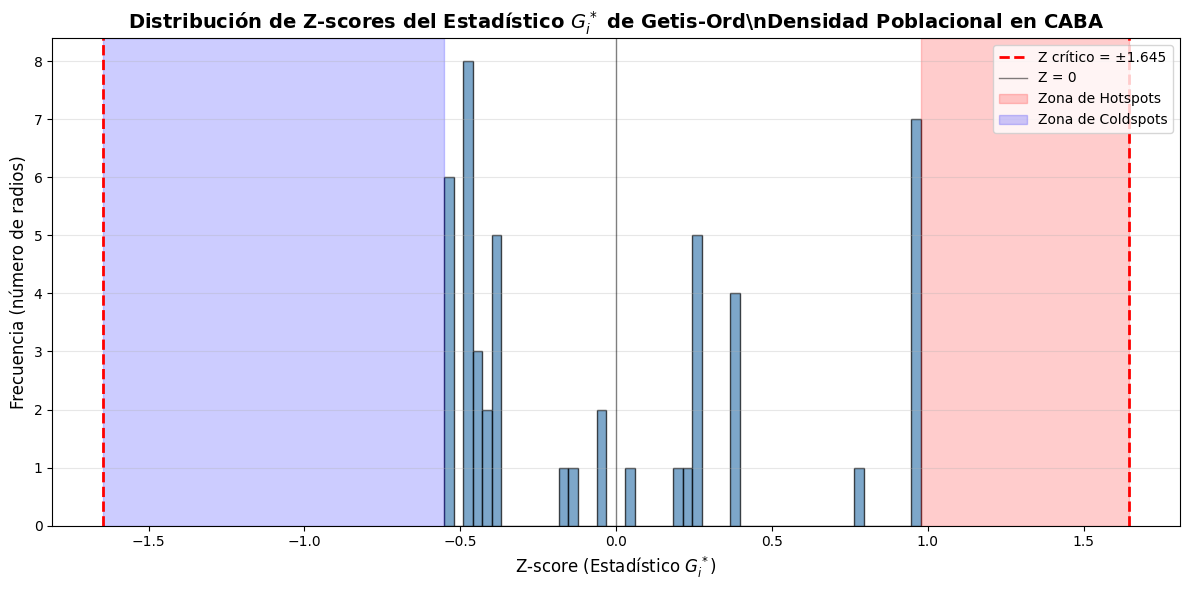

Estadísticas de la distribución de Z-scores:
  Media: -0.011
  Mediana: -0.270
  Desviación estándar: 0.540
  Mínimo: -0.552
  Máximo: 0.978


In [27]:
# Histograma de Z-scores con marcadores de significancia
fig, ax = plt.subplots(figsize=(12, 6))

# Histograma
ax.hist(radios_valid['G_pop_Zs'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')

# Líneas verticales para valores críticos
ax.axvline(z_critical, color='red', linestyle='--', linewidth=2, label=f'Z crítico = ±{z_critical}')
ax.axvline(-z_critical, color='red', linestyle='--', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Z = 0')

# Áreas sombreadas para hotspots y coldspots
ax.axvspan(z_critical, radios_valid['G_pop_Zs'].max(), alpha=0.2, color='red', label='Zona de Hotspots')
ax.axvspan(radios_valid['G_pop_Zs'].min(), -z_critical, alpha=0.2, color='blue', label='Zona de Coldspots')

ax.set_xlabel('Z-score (Estadístico $G_i^*$)', fontsize=12)
ax.set_ylabel('Frecuencia (número de radios)', fontsize=12)
ax.set_title('Distribución de Z-scores del Estadístico $G_i^*$ de Getis-Ord\\nDensidad Poblacional en CABA', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estadísticas de la distribución de Z-scores:")
print(f"  Media: {radios_valid['G_pop_Zs'].mean():.3f}")
print(f"  Mediana: {radios_valid['G_pop_Zs'].median():.3f}")
print(f"  Desviación estándar: {radios_valid['G_pop_Zs'].std():.3f}")
print(f"  Mínimo: {radios_valid['G_pop_Zs'].min():.3f}")
print(f"  Máximo: {radios_valid['G_pop_Zs'].max():.3f}")

## Paso 7: Análisis de Hotspots y Coldspots por Barrio

Agregamos información de barrios para identificar qué zonas de CABA presentan mayor concentración de hotspots o coldspots.

In [28]:
# ============================================
# RESUMEN DE RESULTADOS
# ============================================

print("=" * 100)
print("RESUMEN DEL ANÁLISIS DE HOTSPOTS/COLDSPOTS")
print("=" * 100)

# Verificar si hay clusters significativos
has_significant = 'Hotspot (HH)' in radios_valid['cluster_type'].values

if has_significant:
    print(f"\n✓ Se encontraron clusters estadísticamente significativos")
    print(f"  Nivel de significancia: α = {alpha}")
    print(f"  Valor crítico: |Z| > {z_critical:.3f}\n")
    
    print(f"{'Tipo de Cluster':<25} {'Cantidad':<12} {'Porcentaje':<12} {'Dens. Prom.':<15} {'Z-score Prom.'}")
    print("-" * 100)
    
    for cluster_type in ['Hotspot (HH)', 'Coldspot (LL)', 'No Significativo']:
        subset = radios_valid[radios_valid['cluster_type'] == cluster_type]
        count = len(subset)
        pct = 100 * count / len(radios_valid)
        dens_prom = subset['densidad_pob'].mean() if count > 0 else 0
        z_prom = subset['G_pop_Zs'].mean() if count > 0 else 0
        
        print(f"{cluster_type:<25} {count:>10}   {pct:>10.1f}%   {dens_prom:>12,.0f}   {z_prom:>10.2f}")
    
    print("\n" + "=" * 100)
    
    # Mostrar hotspots si existen
    if n_hotspots > 0:
        print(f"\nHOTSPOTS IDENTIFICADOS (n={n_hotspots})")
        print("-" * 100)
        hotspots = radios_valid[radios_valid['cluster_type'] == 'Hotspot (HH)'].sort_values('G_pop_Zs', ascending=False)
        print(f"\n{'#':<4} {'Densidad (hab/km²)':<20} {'Z-score':<12} {'p-value'}")
        print("-" * 100)
        for i, (_, row) in enumerate(hotspots.iterrows(), 1):
            print(f"{i:<4} {row['densidad_pob']:>17,.0f}   {row['G_pop_Zs']:>10.2f}   {row['G_pop_pval']:>10.6f}")
    
    # Mostrar coldspots si existen
    if n_coldspots > 0:
        print(f"\nCOLDSPOTS IDENTIFICADOS (n={n_coldspots})")
        print("-" * 100)
        coldspots = radios_valid[radios_valid['cluster_type'] == 'Coldspot (LL)'].sort_values('G_pop_Zs')
        print(f"\n{'#':<4} {'Densidad (hab/km²)':<20} {'Z-score':<12} {'p-value'}")
        print("-" * 100)
        for i, (_, row) in enumerate(coldspots.iterrows(), 1):
            print(f"{i:<4} {row['densidad_pob']:>17,.0f}   {row['G_pop_Zs']:>10.2f}   {row['G_pop_pval']:>10.6f}")

else:
    # No hay clusters significativos - mostrar tendencias
    print(f"\n⚠️ ADVERTENCIA: Dataset pequeño (n={len(radios_valid)} radios)")
    print(f"   No se detectaron clusters estadísticamente significativos con α={alpha}")
    print(f"   A continuación se muestran las TENDENCIAS de los radios con Z-scores más extremos:\n")
    
    print(f"{'Categoría':<25} {'Cantidad':<12} {'Porcentaje':<12} {'Dens. Prom.':<15} {'Z-score Prom.'}")
    print("-" * 100)
    
    for cluster_type in ['Tendencia Hotspot', 'Tendencia Coldspot', 'No Significativo']:
        subset = radios_valid[radios_valid['cluster_type'] == cluster_type]
        count = len(subset)
        pct = 100 * count / len(radios_valid)
        dens_prom = subset['densidad_pob'].mean() if count > 0 else 0
        z_prom = subset['G_pop_Zs'].mean() if count > 0 else 0
        
        print(f"{cluster_type:<25} {count:>10}   {pct:>10.1f}%   {dens_prom:>12,.0f}   {z_prom:>10.2f}")
    
    print("\n" + "=" * 100)
    print("\nRADIOS CON MAYOR TENDENCIA A HOTSPOT (Top Z-scores)")
    print("-" * 100)
    top_hot = radios_valid.nlargest(10, 'G_pop_Zs')
    print(f"\n{'#':<4} {'Densidad (hab/km²)':<20} {'Z-score':<12} {'p-value'}")
    print("-" * 100)
    for i, (_, row) in enumerate(top_hot.iterrows(), 1):
        print(f"{i:<4} {row['densidad_pob']:>17,.0f}   {row['G_pop_Zs']:>10.2f}   {row['G_pop_pval']:>10.6f}")
    
    print("\n" + "=" * 100)
    print("\nRADIOS CON MAYOR TENDENCIA A COLDSPOT (Bottom Z-scores)")
    print("-" * 100)
    top_cold = radios_valid.nsmallest(10, 'G_pop_Zs')
    print(f"\n{'#':<4} {'Densidad (hab/km²)':<20} {'Z-score':<12} {'p-value'}")
    print("-" * 100)
    for i, (_, row) in enumerate(top_cold.iterrows(), 1):
        print(f"{i:<4} {row['densidad_pob']:>17,.0f}   {row['G_pop_Zs']:>10.2f}   {row['G_pop_pval']:>10.6f}")

print("\n" + "=" * 100)

RESUMEN DEL ANÁLISIS DE HOTSPOTS/COLDSPOTS

⚠️ ADVERTENCIA: Dataset pequeño (n=48 radios)
   No se detectaron clusters estadísticamente significativos con α=0.1
   A continuación se muestran las TENDENCIAS de los radios con Z-scores más extremos:

Categoría                 Cantidad     Porcentaje   Dens. Prom.     Z-score Prom.
----------------------------------------------------------------------------------------------------
Tendencia Hotspot                 10         20.8%        846,022         0.84
Tendencia Coldspot                10         20.8%         42,107        -0.53
No Significativo                  28         58.3%        379,779        -0.13


RADIOS CON MAYOR TENDENCIA A HOTSPOT (Top Z-scores)
----------------------------------------------------------------------------------------------------

#    Densidad (hab/km²)   Z-score      p-value
----------------------------------------------------------------------------------------------------
1              821,302      

## Paso 8: Top Barrios con Mayor Concentración de Hotspots y Coldspots

In [29]:
# Estadísticas adicionales
print("=" * 100)
print("ESTADÍSTICAS DE Z-SCORES")
print("=" * 100)

# Por tipo de cluster
for cluster_type in ['Hotspot (HH)', 'Coldspot (LL)', 'No Significativo']:
    subset = radios_valid[radios_valid['cluster_type'] == cluster_type]
    if len(subset) > 0:
        print(f"\n{cluster_type}:")
        print(f"  N = {len(subset)}")
        print(f"  Z-score promedio:  {subset['G_pop_Zs'].mean():>10.3f}")
        print(f"  Z-score mínimo:    {subset['G_pop_Zs'].min():>10.3f}")
        print(f"  Z-score máximo:    {subset['G_pop_Zs'].max():>10.3f}")
        print(f"  Desv. estándar:    {subset['G_pop_Zs'].std():>10.3f}")

print("\n" + "=" * 100)

ESTADÍSTICAS DE Z-SCORES

No Significativo:
  N = 28
  Z-score promedio:      -0.131
  Z-score mínimo:        -0.469
  Z-score máximo:         0.387
  Desv. estándar:         0.325



## Paso 9: Mapa de Barrios Coloreado por Concentración de Hotspots

C:\Users\tomas\AppData\Local\Temp\ipykernel_24360\1809935058.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[0].legend(loc='upper right', fontsize=11)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


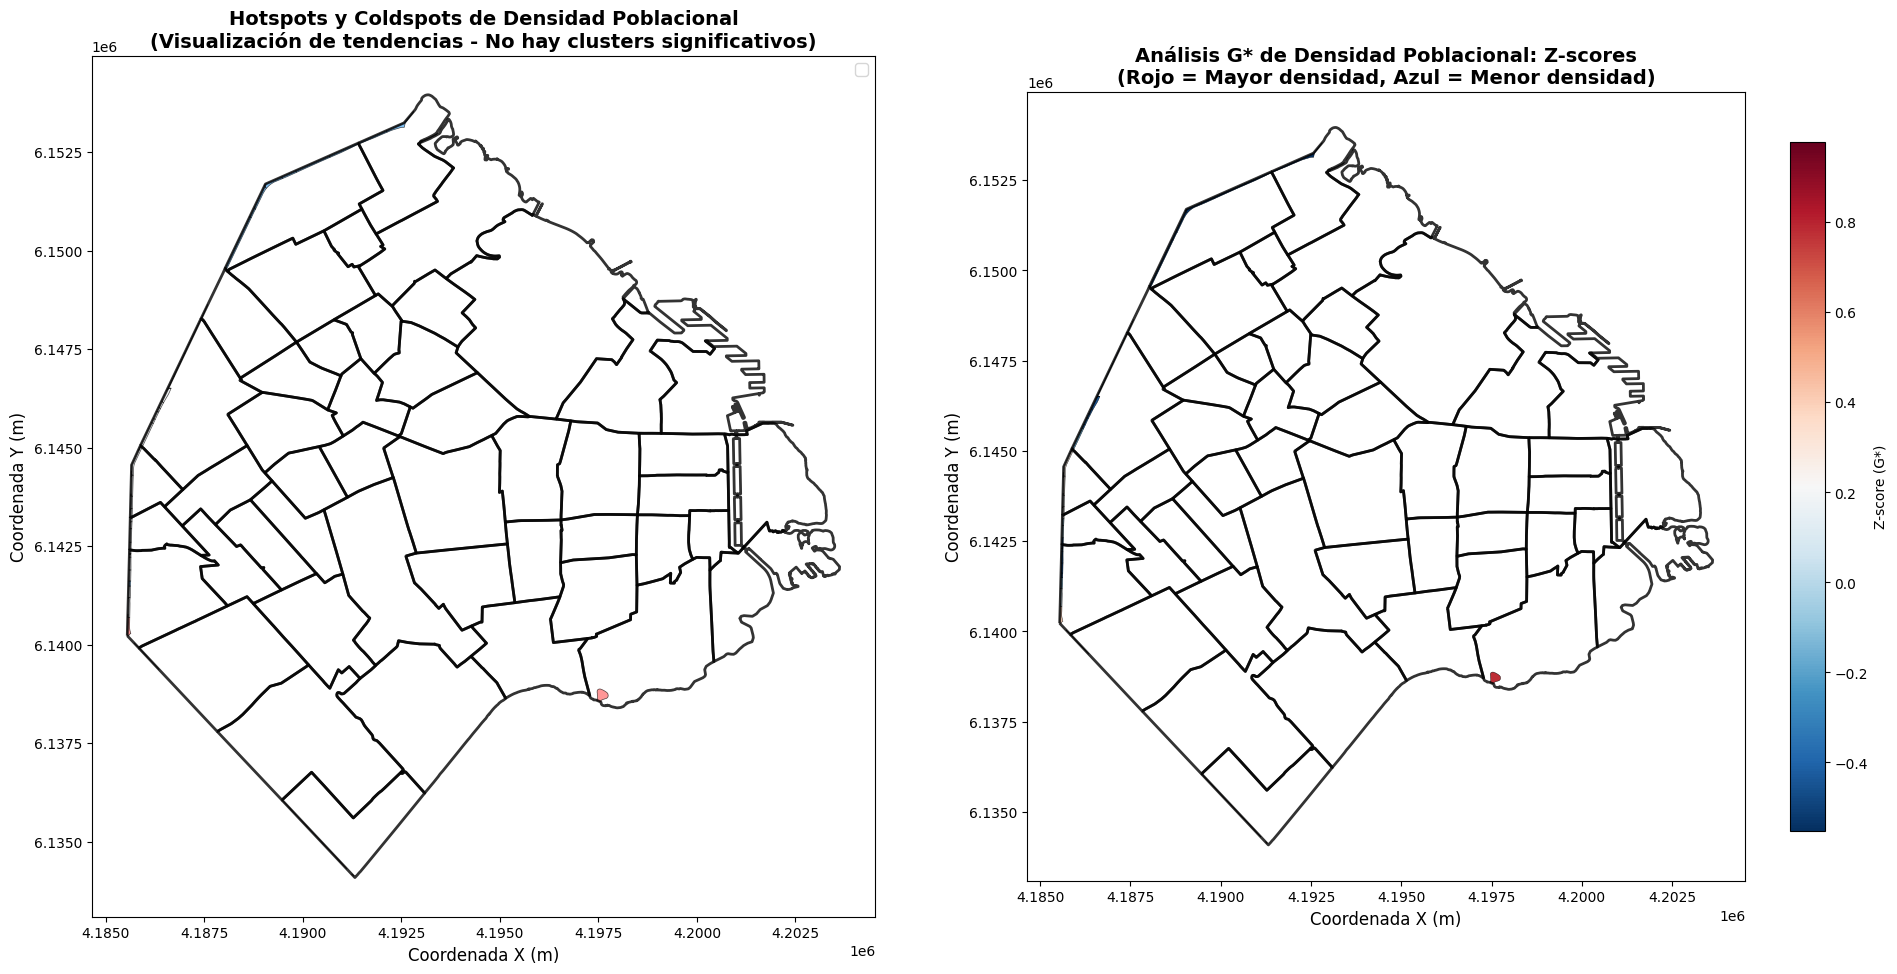


Estadísticas del mapa de Z-scores:
  Z-score mínimo: -0.552
  Z-score máximo: 0.978
  Rango:          1.530


In [30]:
# Visualización de RADIOS CENSALES coloreados por cluster type
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Definir colores según el tipo de clasificación
if 'Hotspot (HH)' in radios_valid['cluster_type'].values:
    # Si hay clusters significativos, usar colores tradicionales
    colors_map = {
        'Hotspot (HH)': 'red',
        'Coldspot (LL)': 'blue',
        'No Significativo': 'lightgray'
    }
    title_suffix = f"\n(α={alpha}, |Z| > {z_critical:.2f})"
else:
    # Si no hay clusters significativos, mostrar tendencias
    colors_map = {
        'Tendencia Hotspot': '#ff6b6b',
        'Tendencia Coldspot': '#4dabf7',
        'No Significativo': '#e9ecef'
    }
    title_suffix = "\n(Visualización de tendencias - No hay clusters significativos)"

# Mapa 1: Radios censales coloreados por tipo de cluster
for cluster_type, color in colors_map.items():
    subset = radios_valid[radios_valid['cluster_type'] == cluster_type]
    if len(subset) > 0:
        subset.plot(ax=axes[0], color=color, edgecolor='black', linewidth=0.5, 
                   label=f"{cluster_type} (n={len(subset)})", alpha=0.7)

barrios_caba.boundary.plot(ax=axes[0], color='black', linewidth=2, alpha=0.8)
axes[0].legend(loc='upper right', fontsize=11)
axes[0].set_title('Hotspots y Coldspots de Densidad Poblacional' + title_suffix, 
                   fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coordenada X (m)', fontsize=12)
axes[0].set_ylabel('Coordenada Y (m)', fontsize=12)
axes[0].set_aspect('equal')

# Mapa 2: Radios coloreados por Z-score continuo
radios_plot = radios_valid.plot(
    column='G_pop_Zs',
    cmap='RdBu_r',
    legend=True,
    ax=axes[1],
    edgecolor='black',
    linewidth=0.3,
    legend_kwds={'label': 'Z-score (G*)', 'shrink': 0.8},
    vmin=radios_valid['G_pop_Zs'].min(),
    vmax=radios_valid['G_pop_Zs'].max()
)

barrios_caba.boundary.plot(ax=axes[1], color='black', linewidth=2, alpha=0.8)
axes[1].set_title('Análisis G* de Densidad Poblacional: Z-scores\n(Rojo = Mayor densidad, Azul = Menor densidad)', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Coordenada X (m)', fontsize=12)
axes[1].set_ylabel('Coordenada Y (m)', fontsize=12)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# Mostrar estadísticas del mapa
print("\nEstadísticas del mapa de Z-scores:")
print(f"  Z-score mínimo: {radios_valid['G_pop_Zs'].min():.3f}")
print(f"  Z-score máximo: {radios_valid['G_pop_Zs'].max():.3f}")
print(f"  Rango:          {radios_valid['G_pop_Zs'].max() - radios_valid['G_pop_Zs'].min():.3f}")